In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'1.2.1'

In [3]:
import numpy as np

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

### Setting up some data

In [6]:
# circle one
num_samples=100
phi = np.linspace(0, np.pi * 5, num_samples)
r = np.linspace(0, 10, num_samples)

x1 = np.cos(phi)*r
y1 = np.sin(phi)*r

labels1 = np.zeros((num_samples,))

In [7]:
# circle one
num_samples=100
phi = np.linspace(0 + np.pi/2, np.pi * 5 + np.pi/2, num_samples)
r = np.linspace(0, 10, num_samples)

x2 = np.cos(phi)*r
y2 = np.sin(phi)*r

labels2 = np.ones((num_samples,))

In [8]:
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])
labels = np.concatenate([labels1, labels2])

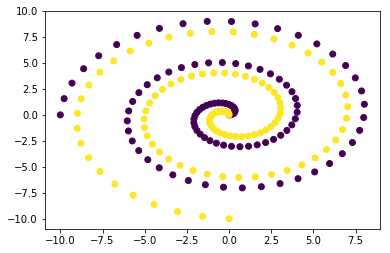

In [9]:
plt.figure()
plt.scatter(x, y, c=labels)

In [10]:
train_x = np.array(x)
train_y = np.array(y)
train_labels = np.array(labels)

In [11]:
train_x.max()

8.015796467319559

### Setting up the network

In [12]:
dims = [10, 100, 100, 2]
activations = ["sigmoid", "sigmoid", "sigmoid", "sigmoid"]

in_tensor = tf.placeholder(tf.float32, [None, dims[0]])
in_tensor

<tf.Tensor 'Placeholder:0' shape=(?, 10) dtype=float32>

In [13]:
tensor = in_tensor

for prev_dim, next_dim, activation in zip(dims[:-1], dims[1:], activations):
    W = tf.Variable(tf.truncated_normal([prev_dim, next_dim]))
    b = tf.Variable(tf.truncated_normal([next_dim]))
    
    tensor = tf.matmul(tensor, W) + b
    
    if activation=="relu":
        tensor = tf.nn.relu(tensor)
    if activation=="sigmoid":
        tensor = tf.nn.sigmoid(tensor)
    
tensor = tf.nn.softmax(tensor)
out_tensor = tensor
out_tensor

<tf.Tensor 'Softmax:0' shape=(?, 2) dtype=float32>

In [14]:
in_labels = tf.placeholder(tf.int32, [None, ])
oh_labels = tf.one_hot(in_labels, depth=dims[-1])

In [15]:
loss = tf.reduce_mean( tf.square(out_tensor - oh_labels))

In [16]:
lr = 1e-3
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss)

### Start the training

In [17]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [18]:
def extract_features(x, y, num_features=None):
    
    assert num_features>0
    
    features = np.zeros((len(x), num_features))
    features[:, 0]=x
    features[:, 1]=y
    features[:, 2]=0 #x**2
    features[:, 3]=0 #y**2
    features[:, 4]=0 #x*y
    
    return features

In [19]:
num_samples = len(train_x)
batch_size = 2

def generate_batch():
    idx = np.random.choice(num_samples, batch_size, replace=False)

    x = train_x[idx]
    y = train_y[idx]
    labels = train_labels[idx]

    features = extract_features(x, y, num_features=dims[0])
    
    return features, labels

In [20]:
for i in range(100000):
    features, labels = generate_batch()
    sess.run(train_op, feed_dict={in_tensor:features, in_labels: labels})

In [21]:
range_x = (-10, 10)
range_y = (-10, 10)

res_x = 1000
res_y = 1000

x_coords = np.linspace(*range_x, res_x)
y_coords = np.linspace(*range_y, res_y)

In [22]:
mesh = np.meshgrid(x_coords, y_coords)

In [23]:
x_coords_flat = mesh[0].reshape(-1)
y_coords_flat = mesh[1].reshape(-1)

size_flat = x_coords_flat.shape[0]

In [24]:
img_flat = np.zeros((size_flat, 2))

assert size_flat % batch_size == 0

for i in range(size_flat//batch_size):
    batch_x = x_coords_flat[i*batch_size : (i+1)*batch_size]
    batch_y = y_coords_flat[i*batch_size : (i+1)*batch_size]
    batch_features = extract_features(batch_x, batch_y, num_features=dims[0])
    
    img_flat[i*batch_size: (i+1)*batch_size]= sess.run(out_tensor, feed_dict={in_tensor : batch_features})
    

In [25]:
img = img_flat.reshape((res_x, res_y, 2))

In [26]:
decision = img[:,:,1]>img[:,:,0]

decision = decision[::-1]

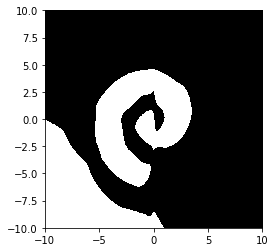

In [27]:
plt.figure()
plt.imshow(decision, cmap="gray", extent=[*range_x, *range_y])
plt.show()